In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader
from wordcloud import WordCloud

import numpy as np
import seaborn as sns

from cities.utils.data_loader import ZoningDataset

smoke_test = "CI" in os.environ
n = 20 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000
n_steps = 10 if smoke_test else 2000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:
census = pd.read_csv(os.path.join(root, "data/minneapolis/processed/census_tracts.csv"))

display(census.head())

print(sorted(census['year'].unique()))

,census_tract,year,housing_units,total_value,median_value,mean_limit_con,median_distance_to_transit,mean_distance_to_transit,housing_units_std,total_value_std,median_value_std,median_distance_to_transit_std,mean_distance_to_transit_std,year_id
0,27053000101,2011,1,150058700.0,112000.0,1.000000,1035.409072,1096.359142,-0.399231,-0.490696,-0.940552,0.633506,0.722698,0
1,27053000101,2013,5,139303800.0,104000.0,1.000000,1040.463235,1097.154819,-0.356586,-0.513758,-1.024849,0.642420,0.724120,1
2,27053000101,2018,2,201663000.0,137000.0,0.856356,1029.540878,1092.579033,-0.388570,-0.380042,-0.677122,0.623156,0.715945,2
3,27053000101,2019,1,220227900.0,151500.0,0.856365,1036.751020,1095.347629,-0.399231,-0.340234,-0.524332,0.635873,0.720891,3
4,27053000102,2011,5,204521700.0,99500.0,1.000000,1409.379828,1467.120389,-0.356586,-0.373913,-1.072267,1.293100,1.385135,0


[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


## median_household_income

In [3]:
income = pd.read_csv(os.path.join(root, "data/minneapolis/sourced/demographic/median_household_income_pre_2020.csv"))

display(income.head())  


# this is a hack, copying the closest years to the missing ones
income['2011'] = income['2013']
income['2012'] = income['2013']

income['2020'] = income['2019']

display(income.head())


income_long = income.melt(id_vars=['tract_id'], var_name='year', value_name='income')

income_long = income_long.rename(columns={'tract_id': 'census_tract'})

display(income_long['census_tract'].dtype)
income_long['year'] = income_long['year'].astype(int)
display(income_long['year'].dtype)


print(census['census_tract'].dtype)
print(census['year'].dtype)

census = pd.merge(census, income_long, on=['census_tract', 'year'])

display(census.head())

print(census.isna().sum())  

,tract_id,2013,2014,2015,2016,2017,2018,2019
0,27053000101,45608,48750,59414,60227,58240,63516,64120
1,27053000102,46055,42053,43438,43234,43021,41691,45615
2,27053000300,66890,66745,65407,67393,71389,74250,76047
3,27053000601,63877,72386,80737,78854,72904,68720,67656
4,27053000603,70128,69875,67019,72132,76818,82984,83984


,tract_id,2013,2014,2015,2016,2017,2018,2019,2011,2012,2020
0,27053000101,45608,48750,59414,60227,58240,63516,64120,45608,45608,64120
1,27053000102,46055,42053,43438,43234,43021,41691,45615,46055,46055,45615
2,27053000300,66890,66745,65407,67393,71389,74250,76047,66890,66890,76047
3,27053000601,63877,72386,80737,78854,72904,68720,67656,63877,63877,67656
4,27053000603,70128,69875,67019,72132,76818,82984,83984,70128,70128,83984


dtype('int64')

dtype('int64')

int64
int64


,census_tract,year,housing_units,total_value,median_value,mean_limit_con,median_distance_to_transit,mean_distance_to_transit,housing_units_std,total_value_std,median_value_std,median_distance_to_transit_std,mean_distance_to_transit_std,year_id,income
0,27053000101,2011,1,150058700.0,112000.0,1.000000,1035.409072,1096.359142,-0.399231,-0.490696,-0.940552,0.633506,0.722698,0,45608
1,27053000101,2013,5,139303800.0,104000.0,1.000000,1040.463235,1097.154819,-0.356586,-0.513758,-1.024849,0.642420,0.724120,1,45608
2,27053000101,2018,2,201663000.0,137000.0,0.856356,1029.540878,1092.579033,-0.388570,-0.380042,-0.677122,0.623156,0.715945,2,63516
3,27053000101,2019,1,220227900.0,151500.0,0.856365,1036.751020,1095.347629,-0.399231,-0.340234,-0.524332,0.635873,0.720891,3,64120
4,27053000102,2011,5,204521700.0,99500.0,1.000000,1409.379828,1467.120389,-0.356586,-0.373913,-1.072267,1.293100,1.385135,0,46055


census_tract                      0
year                              0
housing_units                     0
total_value                       0
median_value                      0
mean_limit_con                    0
median_distance_to_transit        0
mean_distance_to_transit          0
housing_units_std                 0
total_value_std                   0
median_value_std                  0
median_distance_to_transit_std    0
mean_distance_to_transit_std      0
year_id                           0
income                            0
dtype: int64


## segregation_index

In [4]:
segregation = pd.read_csv(os.path.join(root, "data/minneapolis/sourced/demographic/segregation_index_annual_city_pre_2020.csv")) 
    
#TODO overcome this
segregation['2011'] = segregation['2013']
segregation['2012'] = segregation['2013']
segregation['2020'] = segregation['2019']

segregation_long = segregation.melt(id_vars=['tract_id'], var_name='year', value_name='segregation')
segregation_long = segregation_long.rename(columns={'tract_id': 'census_tract'})

segregation_long['year'] = segregation_long['year'].astype(int)

census = pd.merge(census, segregation_long, on=['census_tract', 'year'])

display(census.head())

,census_tract,year,housing_units,total_value,median_value,mean_limit_con,median_distance_to_transit,mean_distance_to_transit,housing_units_std,total_value_std,median_value_std,median_distance_to_transit_std,mean_distance_to_transit_std,year_id,income,segregation
0,27053000101,2011,1,150058700.0,112000.0,1.000000,1035.409072,1096.359142,-0.399231,-0.490696,-0.940552,0.633506,0.722698,0,45608,0.347033
1,27053000101,2013,5,139303800.0,104000.0,1.000000,1040.463235,1097.154819,-0.356586,-0.513758,-1.024849,0.642420,0.724120,1,45608,0.347033
2,27053000101,2018,2,201663000.0,137000.0,0.856356,1029.540878,1092.579033,-0.388570,-0.380042,-0.677122,0.623156,0.715945,2,63516,0.128670
3,27053000101,2019,1,220227900.0,151500.0,0.856365,1036.751020,1095.347629,-0.399231,-0.340234,-0.524332,0.635873,0.720891,3,64120,0.209374
4,27053000102,2011,5,204521700.0,99500.0,1.000000,1409.379828,1467.120389,-0.356586,-0.373913,-1.072267,1.293100,1.385135,0,46055,0.122656


## population_white_non_hispanic

In [5]:
white = pd.read_csv(os.path.join(root, "data/minneapolis/sourced/demographic/population_white_non_hispanic_pre_2020.csv"))
display(white.head())

population = pd.read_csv(os.path.join(root, "data/minneapolis/sourced/demographic/population_pre_2020.csv"))

display(population.head())

white_ratios = white/population
white_ratios['tract_id'] = white['tract_id']
#white_ratios.drop(columns=['tract_id'], inplace=True)


display(white_ratios.head())

,tract_id,2013,2014,2015,2016,2017,2018,2019
0,27053000101,1519,1380,1321,1392,1228,1198,1091
1,27053000102,2094,2133,2262,2154,2162,2142,2035
2,27053000300,2444,2205,2104,2168,2203,2303,2441
3,27053000601,3812,3751,3857,3752,3621,3784,3828
4,27053000603,2529,2562,2513,2622,2539,2515,2546


,tract_id,2013,2014,2015,2016,2017,2018,2019
0,27053000101,3562,3157,3249,3226,3137,3198,3278
1,27053000102,4515,4833,5420,5475,5322,5453,5332
2,27053000300,3271,3274,3180,3200,3132,3307,3204
3,27053000601,5035,4995,4890,5051,5098,4929,5134
4,27053000603,2664,2746,2733,2843,2827,2845,2854


,tract_id,2013,2014,2015,2016,2017,2018,2019
0,27053000101,0.426446,0.437124,0.406587,0.431494,0.391457,0.374609,0.332825
1,27053000102,0.463787,0.441341,0.417343,0.393425,0.406238,0.392811,0.381658
2,27053000300,0.747172,0.673488,0.661635,0.677500,0.703384,0.696402,0.761860
3,27053000601,0.757100,0.750951,0.788753,0.742823,0.710279,0.767701,0.745617
4,27053000603,0.949324,0.932993,0.919502,0.922265,0.898125,0.884007,0.892081


In [6]:

white_ratios['2011'] = white_ratios['2013']
white_ratios['2012'] = white_ratios['2013']

white_ratios['2020'] = white_ratios['2019']

white_long = white_ratios.melt(id_vars=['tract_id'], var_name='year', value_name='white')

white_long = white_long.rename(columns={'tract_id': 'census_tract'})

white_long['year'] = white_long['year'].astype(int)     

census = pd.merge(census, white_long, on=['census_tract', 'year'])

display(census.head())

print(census.isna().sum())

census.to_csv(os.path.join(root, "data/minneapolis/processed/census_tracts_demographic.csv"), index=False)

,census_tract,year,housing_units,total_value,median_value,mean_limit_con,median_distance_to_transit,mean_distance_to_transit,housing_units_std,total_value_std,median_value_std,median_distance_to_transit_std,mean_distance_to_transit_std,year_id,income,segregation,white
0,27053000101,2011,1,150058700.0,112000.0,1.000000,1035.409072,1096.359142,-0.399231,-0.490696,-0.940552,0.633506,0.722698,0,45608,0.347033,0.426446
1,27053000101,2013,5,139303800.0,104000.0,1.000000,1040.463235,1097.154819,-0.356586,-0.513758,-1.024849,0.642420,0.724120,1,45608,0.347033,0.426446
2,27053000101,2018,2,201663000.0,137000.0,0.856356,1029.540878,1092.579033,-0.388570,-0.380042,-0.677122,0.623156,0.715945,2,63516,0.128670,0.374609
3,27053000101,2019,1,220227900.0,151500.0,0.856365,1036.751020,1095.347629,-0.399231,-0.340234,-0.524332,0.635873,0.720891,3,64120,0.209374,0.332825
4,27053000102,2011,5,204521700.0,99500.0,1.000000,1409.379828,1467.120389,-0.356586,-0.373913,-1.072267,1.293100,1.385135,0,46055,0.122656,0.463787


census_tract                      0
year                              0
housing_units                     0
total_value                       0
median_value                      0
mean_limit_con                    0
median_distance_to_transit        0
mean_distance_to_transit          0
housing_units_std                 0
total_value_std                   0
median_value_std                  0
median_distance_to_transit_std    0
mean_distance_to_transit_std      0
year_id                           0
income                            0
segregation                       0
white                             0
dtype: int64


## Explore correlations (sanity check)

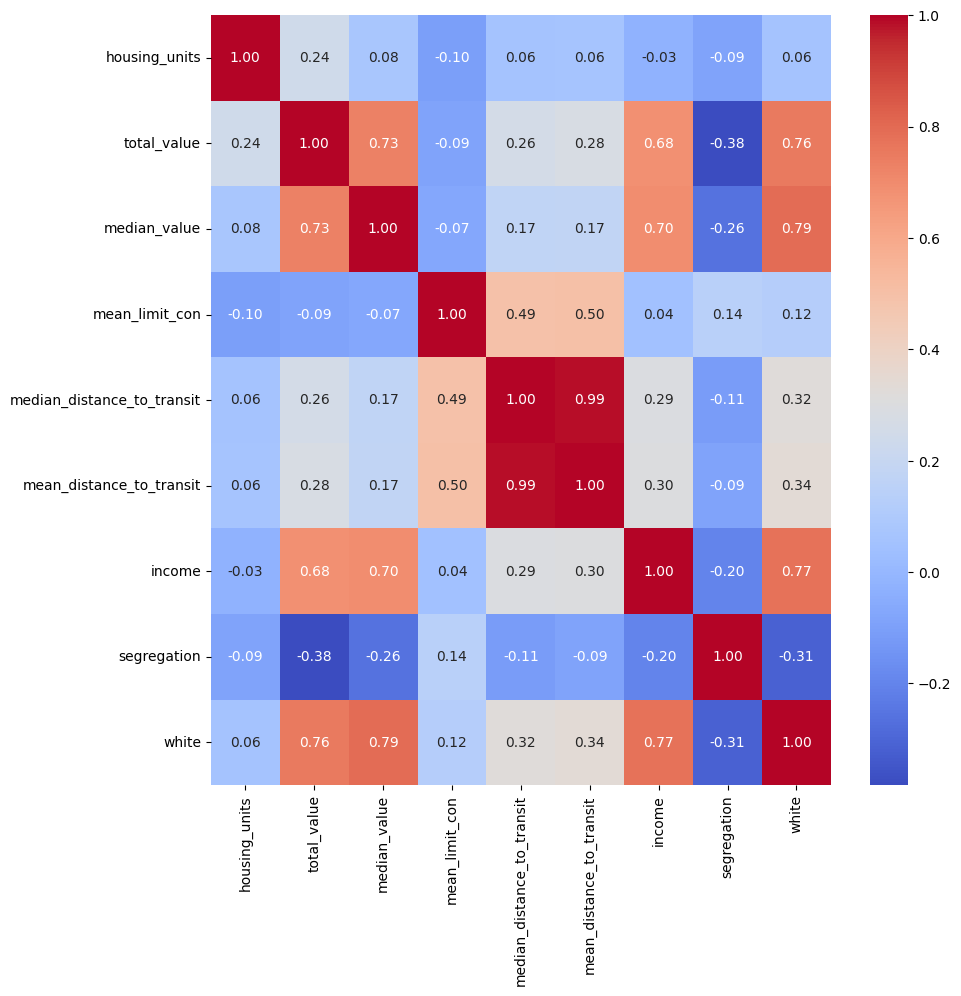

In [7]:
columns = census.columns

vars_to_remove = ['census_tract', 'year', 'year_id'] + [var for var in columns if var.endswith('std')]

vars = [var for var in columns if var not in vars_to_remove] 
#plot spearman correlation between all vars in census[vars]
corr = census[vars].corr(method='spearman')

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# will drop total value as correlated with white and median income
# will keep median

## Export to torch loader

In [8]:
print(census.columns)
display(census.head())  

Index(['census_tract', 'year', 'housing_units', 'total_value', 'median_value',
       'mean_limit_con', 'median_distance_to_transit',
       'mean_distance_to_transit', 'housing_units_std', 'total_value_std',
       'median_value_std', 'median_distance_to_transit_std',
       'mean_distance_to_transit_std', 'year_id', 'income', 'segregation',
       'white'],
      dtype='object')


,census_tract,year,housing_units,total_value,median_value,mean_limit_con,median_distance_to_transit,mean_distance_to_transit,housing_units_std,total_value_std,median_value_std,median_distance_to_transit_std,mean_distance_to_transit_std,year_id,income,segregation,white
0,27053000101,2011,1,150058700.0,112000.0,1.000000,1035.409072,1096.359142,-0.399231,-0.490696,-0.940552,0.633506,0.722698,0,45608,0.347033,0.426446
1,27053000101,2013,5,139303800.0,104000.0,1.000000,1040.463235,1097.154819,-0.356586,-0.513758,-1.024849,0.642420,0.724120,1,45608,0.347033,0.426446
2,27053000101,2018,2,201663000.0,137000.0,0.856356,1029.540878,1092.579033,-0.388570,-0.380042,-0.677122,0.623156,0.715945,2,63516,0.128670,0.374609
3,27053000101,2019,1,220227900.0,151500.0,0.856365,1036.751020,1095.347629,-0.399231,-0.340234,-0.524332,0.635873,0.720891,3,64120,0.209374,0.332825
4,27053000102,2011,5,204521700.0,99500.0,1.000000,1409.379828,1467.120389,-0.356586,-0.373913,-1.072267,1.293100,1.385135,0,46055,0.122656,0.463787


In [9]:
columns_to_standardize = [
    "income",    
    "segregation",
    "white",
    "housing_units",
    "total_value",
    "median_value",
    "median_distance_to_transit",
    "mean_distance_to_transit",
    "mean_limit_con"
]

standardization_dict = {}

for column in columns_to_standardize:
    census[column + "_std"] = (census[column] - census[column].mean()) / census[
        column
    ].std()
    standardization_dict[column] = {
        "mean": census[column].mean(),
        "std": census[column].std(),
    }


columns_to_factorize = [
    "year"
]


for column in columns_to_factorize:
    census[column + "_id"] = pd.factorize(census[column])[0]

display(census.head())

print(standardization_dict)

census.to_csv(os.path.join(root, "data/minneapolis/processed/census_tracts_demographic.csv"), index=False)

,census_tract,year,housing_units,total_value,median_value,mean_limit_con,median_distance_to_transit,mean_distance_to_transit,housing_units_std,total_value_std,...,median_distance_to_transit_std,mean_distance_to_transit_std,year_id,income,segregation,white,income_std,segregation_std,white_std,mean_limit_con_std
0,27053000101,2011,1,150058700.0,112000.0,1.000000,1035.409072,1096.359142,-0.398263,-0.502206,...,0.666031,0.756695,0,45608,0.347033,0.426446,-0.501371,0.588709,-0.646859,0.936101
1,27053000101,2013,5,139303800.0,104000.0,1.000000,1040.463235,1097.154819,-0.354710,-0.526406,...,0.675163,0.758150,1,45608,0.347033,0.426446,-0.501371,0.588709,-0.646859,0.936101
2,27053000101,2018,2,201663000.0,137000.0,0.856356,1029.540878,1092.579033,-0.387375,-0.386087,...,0.655427,0.749780,2,63516,0.128670,0.374609,0.118415,-0.599437,-0.844550,0.479738
3,27053000101,2019,1,220227900.0,151500.0,0.856365,1036.751020,1095.347629,-0.398263,-0.344313,...,0.668455,0.754844,3,64120,0.209374,0.332825,0.139319,-0.160315,-1.003903,0.479767
4,27053000102,2011,5,204521700.0,99500.0,1.000000,1409.379828,1467.120389,-0.354710,-0.379655,...,1.341800,1.434942,0,46055,0.122656,0.463787,-0.485901,-0.632160,-0.504449,0.936101


{'income': {'mean': 60094.5306372549, 'std': 28893.836452033356}, 'segregation': {'mean': 0.23883714966974662, 'std': 0.18378463281007484}, 'white': {'mean': 0.5960596664808411, 'std': 0.26221126861922445}, 'housing_units': {'mean': 37.57720588235294, 'std': 91.84181610416991}, 'total_value': {'mean': 373244336.6862745, 'std': 444410879.6350971}, 'median_value': {'mean': 201312.3161764706, 'std': 94743.77994846534}, 'median_distance_to_transit': {'mean': 666.8277994662651, 'std': 553.3999451593667}, 'mean_distance_to_transit': {'mean': 682.7147296676637, 'std': 546.6462406250295}, 'mean_limit_con': {'mean': 0.7053547779873367, 'std': 0.3147578271963414}}


In [10]:
# categorical
year_id = torch.tensor(census["year_id"].values, dtype=torch.long)

census_tract = torch.tensor(census["census_tract"].values, dtype=torch.long)


# continuous

housing_units = torch.tensor(census["housing_units_std"].values, dtype=torch.float)
housing_units_original = torch.tensor(census["housing_units"].values, dtype=torch.float)

income = torch.tensor(census['income_std'].values, dtype=torch.float32)
income_original = torch.tensor(census['income'].values, dtype=torch.float32)

mean_distance = torch.tensor(census["mean_distance_to_transit_std"].values, dtype=torch.float)
mean_distance_original = torch.tensor(census["mean_distance_to_transit"].values, dtype=torch.float)

mean_limit = torch.tensor(census['mean_limit_con_std'].values, dtype=torch.float32)
mean_limit_original = torch.tensor(census["mean_limit_con"].values, dtype=torch.float)

median_distance = torch.tensor(census["median_distance_to_transit_std"].values, dtype=torch.float)
median_distance_original = torch.tensor(census["median_distance_to_transit"].values, dtype=torch.float)

median_value = torch.tensor(census["median_value_std"].values, dtype=torch.float)
median_value_original = torch.tensor(census["median_value"].values, dtype=torch.float)

segregation = torch.tensor(census['segregation_std'].values, dtype=torch.float32)
segregation_original = torch.tensor(census['segregation'].values, dtype=torch.float32)

total_value = torch.tensor(census["total_value_std"].values, dtype=torch.float)
total_value_original = torch.tensor(census["total_value"].values, dtype=torch.float)

white = torch.tensor(census['white_std'].values, dtype=torch.float32)
white_original = torch.tensor(census['white'].values, dtype=torch.float32)


categorical = {
    "year": year_id,
    "census_tract": census_tract
}

continuous = {
    "housing_units": housing_units,
    "housing_units_original": housing_units_original,
    "income": income,
    "income_original": income_original,
    "mean_distance": mean_distance,
    "mean_distance_original": mean_distance_original,
    "mean_limit": mean_limit,
    "mean_limit_original": mean_limit_original,
    "median_distance": median_distance,
    "median_distance_original": median_distance_original,
    "median_value": median_value,
    "median_value_original": median_value_original,
    "segregation": segregation,
    "segregation_original": segregation_original,
    "total_value": total_value,
    "total_value_original": total_value_original,
    "white": white,
    "white_original": white_original
}


census_tracts_dataset = ZoningDataset(
    categorical, continuous, standardization_dictionary=standardization_dict
)

census_tracts_data_path = os.path.join(root, "data/minneapolis/processed/census_tracts_dataset.pt")

torch.save(census_tracts_dataset, census_tracts_data_path)

print(census_tracts_dataset.n)

print(len(census_tracts_dataset))

816
816
